In [1]:
!nvidia-smi -L

GPU 0: NVIDIA T600 Laptop GPU (UUID: GPU-6eb8b1c8-3f9b-69b0-d2ed-13d96ebedc1c)


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa

print(f'Tensorflow v{tf.__version__}, using {tf.test.gpu_device_name()}')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\33688\anaconda3\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Tensorflow v2.13.0, using 


In [3]:
bert_type = 'bert-base-cased'

In [4]:
from transformers import TFBertModel, BertTokenizerFast

bert = TFBertModel.from_pretrained(bert_type)
tokenizer = BertTokenizerFast.from_pretrained(bert_type)

C:\Users\33688\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\33688\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [5]:
import re
import string

def remove_html_tag(text):
  cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  text = re.sub(cleanr, '', text)
  return text

In [7]:
df = pd.read_csv('IMDB Dataset.csv')
df['clean_text'] = df.review.apply(lambda text: remove_html_tag(text))
df

,review,sentiment,clean_text
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production. The filming tec...
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"Petter Mattei's ""Love in the Time of Money"" is..."
...,...,...,...
49995,I thought this movie did a down right good job...,positive,I thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,"Bad plot, bad dialogue, bad acting, idiotic di..."
49997,I am a Catholic taught in parochial elementary...,negative,I am a Catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,I'm going to have to disagree with the previou...


In [8]:
df.clean_text.apply(lambda x: len(x.split(' '))).describe()

count    50000.00000
mean       227.10428
std        168.26324
min          4.00000
25%        124.00000
50%        170.00000
75%        275.00000
max       2450.00000
Name: clean_text, dtype: float64

In [9]:
from sklearn.model_selection import train_test_split

x = df.clean_text
y = pd.get_dummies(df.sentiment).values
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.2, random_state=42)

x_train = tokenizer.batch_encode_plus(x_train.to_list(),
                                      return_tensors='tf',
                                      max_length=256,
                                      padding='max_length',
                                      truncation=True).values()
x_test = tokenizer.batch_encode_plus(x_test.to_list(),
                                     return_tensors='tf',
                                     max_length=256,
                                     padding='max_length',
                                     truncation=True).values()
x_val = tokenizer.batch_encode_plus(x_val.to_list(),
                                    return_tensors='tf',
                                    max_length=256,
                                    padding='max_length',
                                    truncation=True).values()

In [10]:
# Input
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
token_type_ids = tf.keras.layers.Input(shape=(256,), name='token_type_ids', dtype='int32')
attention_mask = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')
inputs = [input_ids, token_type_ids, attention_mask]
# Output
outputs = bert(inputs)[1]
outputs = tf.keras.layers.Dropout(0.1, name='dropout')(outputs)
outputs = tf.keras.layers.Dense(2, activation='softmax', name='classifier')(outputs)
# Generate Model
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='bert_classifier')
model.summary()

Model: "bert_classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                    

In [17]:
lr = 2e-5
epochs = 2
batch_size = 32

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=[tf.keras.metrics.CategoricalAccuracy(), 
                       tfa.metrics.F1Score(2)])

In [19]:
history = model.fit(x_train, 
                    y_train, 
                    validation_data=(x_val, y_val), 
                    epochs=epochs, 
                    batch_size=batch_size)

Epoch 1/2
1000/1000 [==============================] - 36998s 37s/step - loss: 0.2099 - categorical_accuracy: 0.9181 - f1_score: 0.9181 - val_loss: 0.1958 - val_categorical_accuracy: 0.9236 - val_f1_score: 0.9236
Epoch 2/2
1000/1000 [==============================] - 36710s 37s/step - loss: 0.1212 - categorical_accuracy: 0.9569 - f1_score: 0.9569 - val_loss: 0.2269 - val_categorical_accuracy: 0.9206 - val_f1_score: 0.9206


In [20]:
result = model.evaluate(x_test, y_test)

313/313 [==============================] - 2307s 7s/step - loss: 0.2227 - categorical_accuracy: 0.9184 - f1_score: 0.9184


In [21]:
from tensorflow.keras.models import load_model

In [22]:
model.save("modele_bert.h5")

C:\Users\33688\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
model.save("modele_bert_keras.keras")

C:\Users\33688\anaconda3\Lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [24]:
loaded_model=load_model("modele_bert.h5")

ValueError: Unknown layer: 'TFBertModel'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
predictions=loaded_model.predict(nouvelles_donnees)

C:\Users\33688\AppData\Local\Temp\ipykernel_5532\2263449784.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


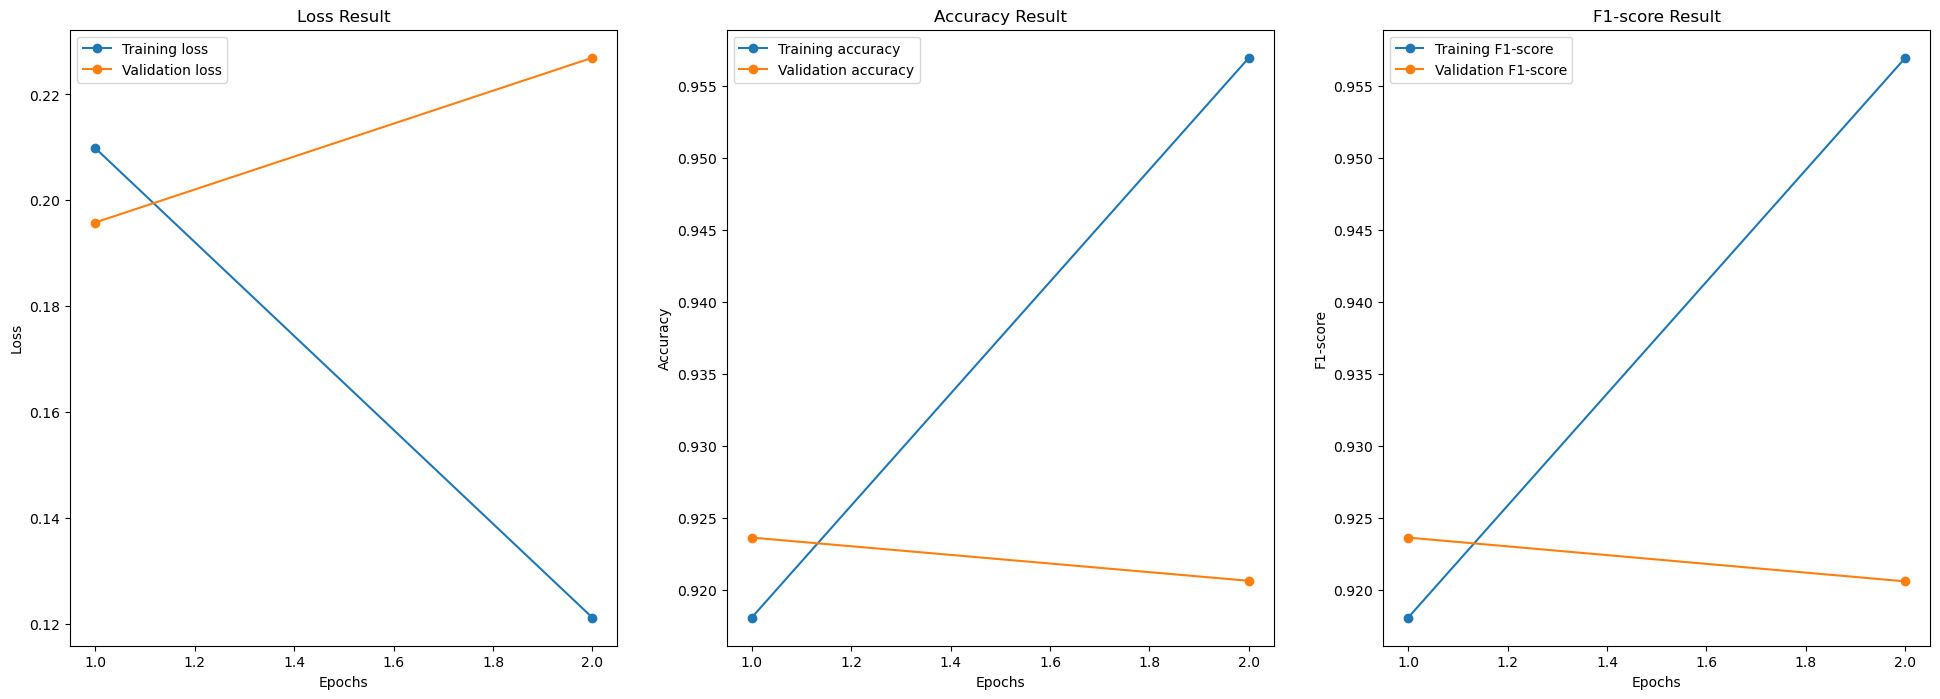

In [25]:
import matplotlib.pyplot as plt

history = history.history
epoch_range = np.arange(1, epochs+1)
# Initialize subplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
# Plot loss
ax1.set_title('Loss Result')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(epoch_range, history['loss'], '-o', label='Training loss')
ax1.plot(epoch_range, history['val_loss'], '-o', label='Validation loss')
ax1.legend()
# Plot accuracy
ax2.set_title('Accuracy Result')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.plot(epoch_range, history['categorical_accuracy'], '-o', label='Training accuracy')
ax2.plot(epoch_range, history['val_categorical_accuracy'], '-o', label='Validation accuracy')
ax2.legend()
# Plot F1-score
ax3.set_title('F1-score Result')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('F1-score')
ax3.plot(epoch_range, np.mean(history['f1_score'], axis=1), '-o', label='Training F1-score')
ax3.plot(epoch_range, np.mean(history['val_f1_score'], axis=1), '-o', label='Validation F1-score')
ax3.legend()
# Show plot
fig.show()